<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/NLP/TFIDF%2BN_GRAMS%2BPOS%2BOTHER_FEATURES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction

In this notebook we will work with the following configuration when doing vectorization: **TFIDF + N-grams + POS Tagging + Other features**

The objective of this notebook is to classify the tweets *(pre-processed)* by applying various classification algorithms to the vectorized data.

## Libraries

In [ ]:
import io
import pandas as pd
from google.colab import files
import re
import numpy as np
import seaborn as sns
import pickle

from ast import literal_eval
import nltk
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer

## 1. Loading Data

We start by loading the data file that contains the preprocessing tweets with which the study will work. The file format to upload is CSV.

For this purpose, you must have the *preprocessed_data.csv* file loaded in this notebook.

In [ ]:
df = pd.read_csv('./prepocessed_data.csv', sep=',')

with_e = []
without_e = []
for i in range(0,len(df)):
  without_e.append(literal_eval(df.iloc[i]['preprocessing_without_emoticons']))
  with_e.append(literal_eval(df.iloc[i]['preprocessing_with_emoticons']))

df['preprocessing_without_emoticons'] = without_e
df['preprocessing_with_emoticons'] = with_e
df = df.drop(columns=['Unnamed: 0'])
df

,preprocessing_without_emoticons,preprocessing_with_emoticons,class
0,"[woman, complain, cleaning, house, man, always...","[woman, complain, cleaning, house, man, always...",2
1,"[boy, day, cold, tea, bad, coffin, dat, st, pl...","[boy, day, cold, tea, bad, coffin, dat, st, pl...",1
2,"[dawn, ever, fuck, bitch, start, cry, confused...","[dawn, !, !, !, ever, fuck, bitch, start, cry,...",1
3,"[look, like, tranny]","[look, like, tranny]",1
4,"[shit, hear, might, true, might, baker, bitch,...","[shit, hear, might, true, might, baker, bitch,...",1
...,...,...,...
24778,"[mutual, lie, right, trash, mine, bible, scrip...","[mutual, lie, right, !, trash, mine, bible, sc...",1
24779,"[gone, broke, wrong, heart, baby, drove, redne...","[gone, broke, wrong, heart, baby, drove, redne...",2
24780,"[young, buck, anna, eat, dat, nigh, like, aunt...","[young, buck, anna, eat, !, !, dat, nigh, like...",1
24781,"[got, wild, bitch, telling, lie]","[got, wild, bitch, telling, lie]",1


# 2. Vectorization

When the tweets are preprocessed, we can start to obtain information from them.

The goal of this section is to obtain a dataframe with all the information which will be used for the next one, in order to classify the tweets.


## TFIDF + N-grams

In order to start using TFIDF, we will first have to create a TFIDFVectorizer.

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. Three steps at once.

In addition, the N-grams will now be added to it.

In [ ]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer, min_df = 3, ngram_range = (1,3), lowercase = False)
X_TFIDF = vectorizer.fit_transform(df['preprocessing_without_emoticons'])
X_TFIDF

<24783x12806 sparse matrix of type '<class 'numpy.float64'>'
	with 210169 stored elements in Compressed Sparse Row format>

## POS tagging

A Part - Of - Speech tagger processes a sequence of words and attaches a part of speech tag to each word.

In [ ]:
nltk.download('averaged_perceptron_tagger')

list_POS = []
for tweet in df['preprocessing_without_emoticons']:
  sentence = []
  for sent in nltk.pos_tag(tweet):
    sentence.append(sent[1])
  list_POS.append(sentence)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sevil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df['POS'] = list_POS

In [ ]:
def detokenize(tokens):
  return TreebankWordDetokenizer().detokenize(tokens)

In [ ]:
df['detokenized_POS'] = df['POS'].apply(detokenize)

Now, we calculate the TFIDF as previously done with the words. The objective is to obtain a numerical value for each of the grammar categories.

In [ ]:
POSvectorizer = TfidfVectorizer(min_df=1)
X_POS = POSvectorizer.fit_transform(df['detokenized_POS'])
print('Existing grammar categories: ' + str(len(POSvectorizer.get_feature_names())))

Existing grammar categories: 30


## Detokenizator

To do the other features, we have chosen to put back all the tokens that make a sentence. We think that this will make the development of this process easier.

In [ ]:
df['tweets_detokenize_with_emoticon'] = df['preprocessing_with_emoticons'].apply(detokenize)

In [ ]:
df['tweets_detokenize_with_emoticon']

0        woman complain cleaning house man always take ...
1               boy day cold tea bad coffin dat st place!!
2          dawn!!! ever fuck bitch start cry confused shit
3                                         look like tranny
4              shit hear might true might baker bitch told
                               ...                        
24778    mutual lie right! trash mine bible scripture hymn
24779      gone broke wrong heart baby drove redness crazy
24780    young buck anna eat!! dat nigh like aunt fucki...
24781                           got wild bitch telling lie
24782    ruffled near eleven dahlia beautiful color com...
Name: tweets_detokenize_with_emoticon, Length: 24783, dtype: object

### Sentiment analisis

Thanks to sentiment analysis we will identify and extract subjective characteristics from the tweets to be analyzed. To carry out this task, the VADER library will be used. VADER will return the following values:

- Pos: The probability that the sentiment is positive.
- Neu: The probability that the sentiment is neutral.
- Neg: The probability that the sentiment is negative.
- Compound: The normalized composite score that calculates the sum of all the scores, takes a value between -1 and 1.

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer  = SentimentIntensityAnalyzer() 

negative = []
positive = []
neutral = []
compound = []

for tweet in df['tweets_detokenize_with_emoticon']:
  sentiment = sentiment_analyzer.polarity_scores(tweet)
  negative.append(sentiment['neg'])
  positive.append(sentiment['pos'])
  neutral.append(sentiment['neu'])
  compound.append(sentiment['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sevil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


For example, this is a graphical representation of the sentiment analysis from a tweet.

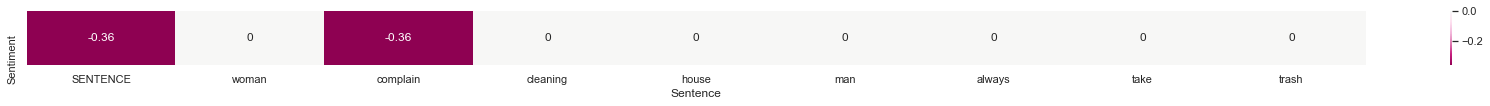

In [ ]:
sns.set(rc={'figure.figsize':(30,1)})
def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

sentence = df['tweets_detokenize_with_emoticon'][0]
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sentiment_analyzer.polarity_scores(sentence)["compound"]] + [sentiment_analyzer.polarity_scores(word)["compound"] for word in sentence.split()]
})

### Number  of  words & sentences

To calculate the number of words and sentences that each tweet has, we have decided to use the original tweet, without preprocessing, since we think that it is more significant in this aspect than the already processed tweet, which removes words.

So, we are going to load the CSV file with the original tweets, but we will only save the tweet column.

In [ ]:
df_count = pd.read_csv('./labeled_data.csv', usecols = ["tweet"])

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
listNumberWords = []

for tweet in df_count['tweet']: 
  aux = []
  words = word_tokenize(tweet)
  num_words = len(words)
  aux.append(num_words)
  listNumberWords.append(aux)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sevil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.tokenize import sent_tokenize

listNumberSentences = []

for tweet in df_count['tweet']:
  aux = []
  sentences = sent_tokenize(tweet)
  num_sentences = len(sentences)
  aux.append(num_sentences)
  listNumberSentences.append(aux)

## Concatenate

In [ ]:
X = np.concatenate([X_TFIDF.toarray(), X_POS.toarray()],axis=1)
X.shape
X = np.column_stack((X,negative,positive,neutral,compound,listNumberWords,listNumberSentences))
X.shape

(24783, 12842)

# 3. Select features

We have created a new dataset where we have put the characteristics with which we will work from now on. With this dataset, feature selection will be made.

To carry out the selection of characteristics, the selectKBest function will be used. You will have to pass it the number of "top" characteristics that it will choose from the existing ones. As each column is a different word and in our problem we are asked to eliminate 70% of the words, we will only have 30% of our vocabulary.

In [ ]:
# Create features and target variable for Classification problem
X_clf = X
y_clf = df['class'] # Target variable: class
n_k = round(X.shape[1] * 0.3)

best = SelectKBest(score_func = mutual_info_classif, k = n_k)

X_new = best.fit_transform(X_clf, y_clf)
print("Shape: ",X.shape)

selected = best.get_support(indices=True)
selected

Shape:  (24783, 12842)


array([    0,     4,     5, ..., 12839, 12840, 12841], dtype=int64)

We keep the new data obtained in a dataframe, in order to make operations in a more comfortable way.

In [ ]:
vectorizers = np.concatenate([vectorizer.get_feature_names(),POSvectorizer.get_feature_names(),['negative'],['positive'],['neutral'],['compound'],['number_words'],['number_sentences']],axis=0)

In [ ]:
features_names = np.asarray(vectorizers)[best.get_support()]

In [ ]:
train_df = pd.DataFrame(X_new,columns=features_names)
train_df

,0,10,11,14,3 two,3 two walk,7,ab,able,abortion,...,vbn,vbp,wdt,wrb,negative,positive,neutral,compound,number_words,number_sentences
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.386868,0.0,0.0,0.263,0.000,0.737,-0.3612,34.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.338,0.000,0.662,-0.6229,26.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.851,0.000,0.149,-0.9530,35.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000,0.556,0.444,0.3612,20.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.487,0.184,0.329,-0.6808,43.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000,0.000,1.000,0.0000,43.0,4.0
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.437635,0.000000,0.0,0.0,0.624,0.000,0.376,-0.8074,15.0,1.0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000,0.255,0.745,0.4738,17.0,2.0
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.487,0.000,0.513,-0.5859,7.0,1.0


# 4. Classification algorithm

## Detaching the dataset

Once we know the characteristics with which we are going to work, it is time to separate the dataset records in the training part and the test part. The test part will be made up of 30% of the tweets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_clf, test_size=0.3, random_state=0)

With the following function, we can draw the resulting confusion matrix by executing the classification algorithms.



In [ ]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    
    if not title:
        if normalize: title = 'Normalized confusion matrix'
        else: title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else: print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = 'Predicted label')
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center", color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Naive Bayes algorithm

This algorithm is based on Bayes' Theorem. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

### Setting Parameters

We are going to try all the possible classifiers with which to carry out the algorithms, to get the most efficient one.

In [ ]:
names = ['GaussianNB','BernouilliNB']
# MultinomialNB and ComplementNB return negative results
classifiers = [GaussianNB(),BernoulliNB()]

for classifier,name in zip(classifiers,names):
  clf = classifier
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X = X_test)
  acc = accuracy_score(y_test,y_pred)
  print('Accuracy of the model {}: {}'.format(name,acc))

Accuracy of the model GaussianNB: 0.425689307330195
Accuracy of the model BernouilliNB: 0.8645595158036314


### Executing the algorithm

In [ ]:
clf = BernoulliNB() # Classifier chosen
clf.fit(X_train, y_train)
y_pred = clf.predict( X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8645595158036314


### Cross validation

Now, we are going to check by cross validation that the model is correct, for this, we will make 7 splits, and we will compare the average of these with the previously obtained result, if they are similar, the model can be considered valid.

In [ ]:
kf = KFold(n_splits=7)
clf = BernoulliNB()
clf.fit(X_train, y_train) 
scores = cross_val_score(clf, X_train, y_train, cv = kf, scoring = "accuracy")
print("Accuracy of each iteration: ", scores)
print("Average: ", scores.mean())

Accuracy of each iteration:  [0.85760387 0.8741428  0.85189669 0.86037127 0.86319613 0.86158192
 0.87530266]
Average:  0.8634421914751502


### Save the model

Due to the long execution time, we save the model in a .dat file.


In [ ]:
filename = 'OF_NaiveBayes.dat'

with open(filename, 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

with open(filename, 'rb') as handle:
    b = pickle.load(handle)

clf= b

### Results obtained

**Confusion Matrix**

Thanks to the following confusion matrix, we can visualize the performance of the algorithm that we have executed.

Normalized confusion matrix
[[0.13348946 0.735363   0.13114754]
 [0.01426831 0.94031669 0.045415  ]
 [0.00237906 0.23076923 0.7668517 ]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

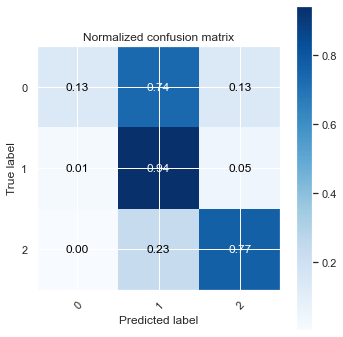

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')

**Classification Report**

Thanks to the classification of the report, we will be able to obtain more specific and interpretable information, thanks to the precision, recall, f1-score and support attributes.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.13      0.20       427
           1       0.90      0.94      0.92      5747
           2       0.75      0.77      0.76      1261

    accuracy                           0.86      7435
   macro avg       0.68      0.61      0.63      7435
weighted avg       0.85      0.86      0.85      7435



## Random Forest

A Random Forest model is made up of a set of individual decision trees, each one trained with a random sample of the training data.

Each tree that makes up the set will predict a class, and the result of the prediction will be the class with the highest number of votes.

### Executing the algorithm

In [ ]:
model = RandomForestClassifier(n_estimators = 500) # Number of trees.
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8586415601882986


### Cross validation

Now, we are going to check by cross validation that the model is correct, for this, we will make 7 splits, and we will compare the average of these with the previously obtained result, if they are similar, the model can be considered valid.

In [ ]:
kf = KFold(n_splits=7)
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train) 
scores = cross_val_score(clf, X_train, y_train, cv = kf, scoring = "accuracy")
print("Accuracy of each iteration: ", scores)
print("Average: ", scores.mean())

Accuracy of each iteration:  [0.85558693 0.85800726 0.85149314 0.8700565  0.85835351 0.86884584
 0.87207425]
Average:  0.8620596336797414


## Save the model

Due to the long execution time, we save the model in a .dat file.


In [ ]:
filename = 'OF_RandomForest.dat'

with open(filename, 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

with open(filename, 'rb') as handle:
    b = pickle.load(handle)

clf= b

### Results obtained

**Confusion Matrix**

Thanks to the following confusion matrix, we can visualize the performance of the algorithm that we have executed.

Normalized confusion matrix
[[0.06557377 0.86885246 0.06557377]
 [0.00609013 0.96328519 0.03062467]
 [0.00317209 0.34655036 0.65027756]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

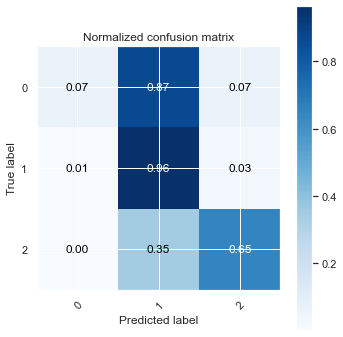

In [ ]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')

**Classification Report**

Thanks to the classification of the report, we will be able to obtain more specific and interpretable information, thanks to the precision, recall, f1-score and support attributes.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.07      0.11       427
           1       0.87      0.96      0.92      5747
           2       0.80      0.65      0.72      1261

    accuracy                           0.86      7435
   macro avg       0.70      0.56      0.58      7435
weighted avg       0.83      0.86      0.84      7435



## Upgrade in classification

As we can see, the previous model predict well the classes 1 and 2, but not the class 0. This is caused because our date is unbalanced, we have much more samples of a class than the others. So, in order to obtain a better result, we are going to train our data in a different way.

With our dataset obtained with the SelectKBest, we added it two new columns, target_1, which corresponds to the column class our preprocessed dataset, and the column target_2, which has only two classes, 0, which represents the 0 class and the 2 class, and the class 1.

In [ ]:
train_df['target_1'] = df['class']
train_df['target_2'] = df['class'].replace({2:0})

In [ ]:
train_df

,0,10,11,14,3 two,3 two walk,7,ab,able,abortion,...,wdt,wrb,negative,positive,neutral,compound,number_words,number_sentences,target_1,target_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.263,0.000,0.737,-0.3612,34.0,3.0,2,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.338,0.000,0.662,-0.6229,26.0,3.0,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.851,0.000,0.149,-0.9530,35.0,4.0,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.556,0.444,0.3612,20.0,2.0,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.487,0.184,0.329,-0.6808,43.0,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,43.0,4.0,1,1
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.624,0.000,0.376,-0.8074,15.0,1.0,2,0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.255,0.745,0.4738,17.0,2.0,1,1
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.487,0.000,0.513,-0.5859,7.0,1.0,1,1


After this, we start to train.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_clf, test_size=0.3, random_state=0)

### Naive Bayes Algorithm

We first train de training data with the target_2.

In [ ]:
clf = BernoulliNB() # Classifier chosen
clf.fit(X_train.drop(['target_1','target_2'],axis=1), X_train['target_2'])

BernoulliNB()

Then, we drop from the training data the samples with value 1.

In [ ]:
X_train_others = X_train.drop(X_train[X_train['target_2']==1].index)

In [ ]:
X_train_others

,0,10,11,14,3 two,3 two walk,7,ab,able,abortion,...,wdt,wrb,negative,positive,neutral,compound,number_words,number_sentences,target_1,target_2
3078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.294,0.706,0.3612,14.0,1.0,2,0
6366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,13.0,1.0,2,0
1069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.200,0.000,0.800,-0.3612,41.0,1.0,2,0
17399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,21.0,2.0,2,0
18054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.154,0.405,0.441,0.6908,42.0,2.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,9.0,1.0,0,0
5072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.688,0.000,0.312,-0.6597,9.0,1.0,0,0
2163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.199,0.450,0.351,0.3182,25.0,1.0,0,0
17089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.195,0.000,0.805,-0.1779,21.0,2.0,2,0


Now we train the data without ones with the target_1 (which has only 0 and 2)

In [ ]:
clf_2 = BernoulliNB() # Classifier chosen
clf_2.fit(X_train_others.drop(['target_1','target_2'],axis=1), X_train_others['target_1'])

BernoulliNB()

Now we predict with both models.

In [ ]:
y_pred_target_2 = clf.predict(X = X_test.drop(['target_1','target_2'],axis=1))

In [ ]:
X_test_others = X_test.drop(X_test[X_test['target_2']==1].index)

In [ ]:
y_pred_target_1 = clf_2.predict(X = X_test_others.drop(['target_1','target_2'],axis=1))

In [ ]:
y_pred_target_2

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [ ]:
y_final = np.concatenate((y_pred_target_1,y_pred_target_2))

In [ ]:
y_test = np.concatenate((X_test_others['target_1'],X_test['target_2']))

We visualize the final result.

Normalized confusion matrix
[[0.68510638 0.23640662 0.078487  ]
 [0.07934575 0.92065425 0.        ]
 [0.0111023  0.         0.9888977 ]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

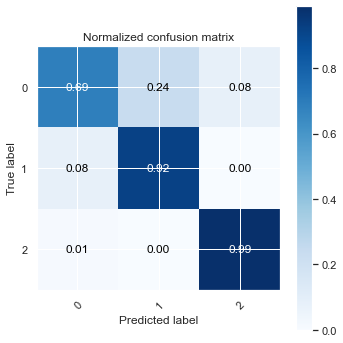

In [ ]:
plot_confusion_matrix(y_test, y_final, classes = unique_labels(y_test, y_final), normalize = True, title = 'Normalized confusion matrix')

As we can see, we have obtained an upgrade in the prediction.

### Random Forest

Now we are going to try it with Random Forest

We first train de training data with the target_2.

In [ ]:
clf = RandomForestClassifier(n_estimators = 500) # Classifier chosen
clf.fit(X_train.drop(['target_1','target_2'],axis=1), X_train['target_2'])

RandomForestClassifier(n_estimators=500)

In [ ]:
X_train_others = X_train.drop(X_train[X_train['target_2']==1].index)

In [ ]:
X_train_others

,0,10,11,14,3 two,3 two walk,7,ab,able,abortion,...,wdt,wrb,negative,positive,neutral,compound,number_words,number_sentences,target_1,target_2
3078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.294,0.706,0.3612,14.0,1.0,2,0
6366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,13.0,1.0,2,0
1069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.200,0.000,0.800,-0.3612,41.0,1.0,2,0
17399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,21.0,2.0,2,0
18054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.154,0.405,0.441,0.6908,42.0,2.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,1.000,0.0000,9.0,1.0,0,0
5072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.688,0.000,0.312,-0.6597,9.0,1.0,0,0
2163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.199,0.450,0.351,0.3182,25.0,1.0,0,0
17089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.195,0.000,0.805,-0.1779,21.0,2.0,2,0


Now we train the data without ones with the target_1 (which has only 0 and 2)

In [ ]:
clf_2 = RandomForestClassifier(n_estimators = 500) # Classifier chosen
clf_2.fit(X_train_others.drop(['target_1','target_2'],axis=1), X_train_others['target_1'])

RandomForestClassifier(n_estimators=500)

In [ ]:
X_test_others = X_test.drop(X_test[X_test['target_2']==1].index)

In [ ]:
y_pred_target_1 = clf_2.predict(X = X_test_others.drop(['target_1','target_2'],axis=1))

In [ ]:
y_pred_target_2

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
y_final = np.concatenate((y_pred_target_1,y_pred_target_2))

In [ ]:
y_test = np.concatenate((X_test_others['target_1'],X_test['target_2']))

Normalized confusion matrix
[[0.59763593 0.33664303 0.06572104]
 [0.04767705 0.95232295 0.        ]
 [0.02379064 0.         0.97620936]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

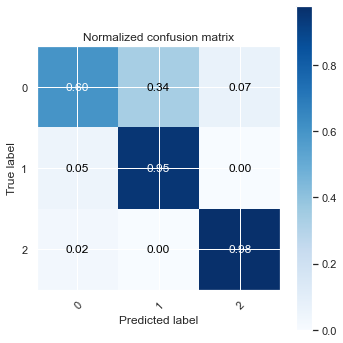

In [ ]:
plot_confusion_matrix(y_test, y_final, classes = unique_labels(y_test, y_final), normalize = True, title = 'Normalized confusion matrix')